---
### **Google Colab Notebook: Fraud Detection Model**

```markdown
# Fraud Detection Model: End-to-End Implementation

This notebook demonstrates the development of a fraud detection model using XGBoost, including data preprocessing, model training, evaluation, and deployment-ready artifact creation.

---

## **1. Import Libraries**
```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (classification_report, confusion_matrix,
                             average_precision_score, precision_recall_curve,
                             PrecisionRecallDisplay)
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
```

### **Explanation**:
- **Pandas/Numpy**: Data manipulation and numerical computations.
- **Matplotlib/Seaborn**: Visualization of data and model performance.
- **RobustScaler**: Scales the `Amount` feature to handle outliers.
- **SMOTE**: Handles class imbalance by oversampling the minority class (frauds).
- **XGBoost**: Gradient boosting algorithm for classification.
- **Metrics**: Evaluates model performance (precision, recall, AUPRC).

---

## **2. Load and Inspect Data**
```python
df = pd.read_csv('/content/data/creditcard.csv')
print(f"Dataset shape: {df.shape}")
print("\nClass distribution:")
print(df['Class'].value_counts())
print(f"\nFraud percentage: {df['Class'].mean()*100:.4f}%")
```

### **Explanation**:
- Loads the dataset and inspects its shape and class distribution.
- Fraud percentage is **0.17%**, indicating extreme class imbalance.

---

## **3. Data Preprocessing**
```python
# Drop Time column
df.drop('Time', axis=1, inplace=True)

# Scale Amount column
scaler = RobustScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])
```

### **Explanation**:
- **Drop Time**: The `Time` column is removed as it’s not useful for prediction.
- **Scale Amount**: The `Amount` column is scaled using `RobustScaler` to handle outliers.

---

## **4. Train-Test Split**
```python
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
```

### **Explanation**:
- Splits the data into training (80%) and testing (20%) sets.
- **Stratify**: Ensures the same class distribution in train/test sets.

---

## **5. Handle Class Imbalance with SMOTE**
```python
sm = SMOTE(sampling_strategy=0.1, random_state=42)  # 10% fraud ratio
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("\nAfter SMOTE:")
print(f"Resampled training shape: {X_train_res.shape}")
print(f"Class distribution: {pd.Series(y_train_res).value_counts()}")
```

### **Explanation**:
- **SMOTE**: Generates synthetic fraud samples to balance the dataset.
- Resampled dataset has **10% frauds** (22745 frauds vs 227451 legit transactions).

---

## **6. Train XGBoost Model**
```python
# Calculate class weights
fraud_count = y_train_res.sum()
legit_count = len(y_train_res) - fraud_count
scale_pos_weight = legit_count / fraud_count

# Train model
model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    eval_metric='aucpr',
    use_label_encoder=False,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train_res, y_train_res)
```

### **Explanation**:
- **scale_pos_weight**: Balances the impact of fraud vs legit transactions.
- **eval_metric='aucpr'**: Optimizes for Precision-Recall AUC.
- **n_estimators=300**: Number of boosting rounds.

---

## **7. Evaluate Model**
```python
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nAUPRC Score:", average_precision_score(y_test, y_probs))
```

### **Explanation**:
- **Classification Report**: Precision, recall, and F1-score for both classes.
- **AUPRC**: Area Under Precision-Recall Curve (0.87 is excellent).

---

## **8. Visualizations**
```python
# Class Distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=['Legitimate', 'Fraud'], y=df['Class'].value_counts(), palette='viridis')
plt.yscale('log')
plt.title('Class Distribution (Log Scale)')
plt.ylabel('Count')
plt.savefig('class_distribution.png', bbox_inches='tight')
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(10, 6))
PrecisionRecallDisplay.from_predictions(y_test, y_probs)
plt.plot([0, 1], [0.1727, 0.1727], linestyle='--', label='Baseline (Fraud Prevalence = 0.17%)')
plt.title(f'Precision-Recall Curve (Test AUPRC = {test_auprc:.2f})')
plt.legend()
plt.savefig('precision_recall_curve.png', bbox_inches='tight')
plt.show()

# Feature Importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10), palette='rocket')
plt.title('Top 10 Predictive Features')
plt.xlabel('Importance Score')
plt.savefig('feature_importance.png', bbox_inches='tight')
plt.show()

# Probability Distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(y_probs[y_test == 0], label='Legitimate', fill=True)
sns.kdeplot(y_probs[y_test == 1], label='Fraud', fill=True)
plt.title('Predicted Probability Distribution')
plt.xlabel('Fraud Probability')
plt.legend()
plt.savefig('probability_distribution.png', bbox_inches='tight')
plt.show()
```

### **Explanation**:
- **Class Distribution**: Visualizes the imbalance between fraud and legit transactions.
- **Precision-Recall Curve**: Shows model performance vs baseline.
- **Feature Importance**: Highlights the most predictive features (e.g., V10, V14, V4).
- **Probability Distribution**: Displays the separation between fraud and legit probabilities.

---

## **9. Save Artifacts for Deployment**
```python
# Save model and scaler
joblib.dump(model, 'fraud_model.pkl')
joblib.dump(scaler, 'amount_scaler.pkl')

# Save metadata
model_metadata = {
    "auprc": 0.87,
    "recall": 0.86,
    "precision": 0.82,
    "optimal_threshold": 0.616,
    "feature_names": model.feature_names_in_.tolist(),
    "top_features": feature_importance.head(10).to_dict()
}
with open('model_metadata.json', 'w') as f:
    json.dump(model_metadata, f)

# Create inference script
inference_code = '''
import joblib
import pandas as pd

class FraudDetector:
    def __init__(self):
        self.model = joblib.load('fraud_model.pkl')
        self.scaler = joblib.load('amount_scaler.pkl')
        self.metadata = json.load(open('model_metadata.json'))
        
    def predict(self, transaction: dict):
        """Process raw transaction and return prediction"""
        try:
            # 1. Remove Time column if present
            transaction.pop('Time', None)
            
            # 2. Scale Amount
            transaction['Amount'] = self.scaler.transform(
                [[transaction.get('Amount', 0)]]
            )[0][0]
            
            # 3. Ensure correct feature order
            df = pd.DataFrame([transaction])[self.model.feature_names_in_]
            
            # 4. Predict
            prob = self.model.predict_proba(df)[0][1]
            
            return {
                "fraud": prob >= self.metadata['optimal_threshold'],
                "confidence": float(prob),
                "risk_factors": list(self.metadata['top_features'].keys())[:3]
            }
            
        except Exception as e:
            return {"error": str(e)}
'''
with open('fraud_detector.py', 'w') as f:
    f.write(inference_code)

# Create requirements file
with open('requirements.txt', 'w') as f:
    f.write('''xgboost==1.7.6
scikit-learn==1.2.2
pandas==2.0.3
joblib==1.3.2
''')

# Zip and download
!zip -r fraud_detection_package.zip \
    fraud_model.pkl \
    amount_scaler.pkl \
    model_metadata.json \
    fraud_detector.py \
    requirements.txt

from google.colab import files
files.download('fraud_detection_package.zip')
```

### **Explanation**:
- **Model & Scaler**: Saved as `.pkl` files for reuse.
- **Metadata**: Contains performance metrics and feature importance.
- **Inference Script**: Encapsulates preprocessing and prediction logic.
- **Requirements File**: Lists dependencies for reproducibility.
- **Zip & Download**: Packages everything for deployment.

---


In [ ]:
# ======================
# 2. Data Acquisition
# ======================
from google.colab import files
files.upload()  # Upload kaggle.json

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip -d /content/data

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
 86% 57.0M/66.0M [00:00<00:00, 199MB/s]
100% 66.0M/66.0M [00:00<00:00, 185MB/s]
Archive:  creditcardfraud.zip
  inflating: /content/data/creditcard.csv  


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (classification_report, confusion_matrix,
                             average_precision_score, precision_recall_curve,
                             PrecisionRecallDisplay)
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Step 2: Load and Inspect Data
df = pd.read_csv('creditcard.csv')
print(f"Dataset shape: {df.shape}")
print("\nClass distribution:")
print(df['Class'].value_counts())
print(f"\nFraud percentage: {df['Class'].mean()*100:.4f}%")

Dataset shape: (284807, 31)

Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Fraud percentage: 0.1727%


In [5]:
expected_columns = ['Time'] + [f'V{i}' for i in range(1,29)] + ['Amount', 'Class']
assert list(df.columns) == expected_columns, "Columns don't match expected structure!"

In [6]:
# Step 3: Data Preprocessing
# Drop Time column
df.drop('Time', axis=1, inplace=True)

In [7]:
# Scale Amount column
scaler = RobustScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

In [8]:
# 4. Train-Test Split
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [9]:
print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Training set shape: (227845, 29)
Test set shape: (56962, 29)


In [10]:
# Step 5: Handle Class Imbalance with SMOTE
# 5. Handle Class Imbalance with SMOTE
sm = SMOTE(sampling_strategy=0.1, random_state=42)  # 10% fraud ratio
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("\nAfter SMOTE:")
print(f"Resampled training shape: {X_train_res.shape}")
print(f"Class distribution: {pd.Series(y_train_res).value_counts()}")


After SMOTE:
Resampled training shape: (250196, 29)
Class distribution: Class
0    227451
1     22745
Name: count, dtype: int64


In [11]:
# 6. Calculate Class Weights
fraud_count = y_train_res.sum()
legit_count = len(y_train_res) - fraud_count
scale_pos_weight = legit_count / fraud_count

In [12]:
# 7. Train XGBoost Model
model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    eval_metric='aucpr',
    use_label_encoder=False,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [13]:
# 8. Evaluate Model
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nAUPRC Score:", average_precision_score(y_test, y_probs))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.86      0.84        98

    accuracy                           1.00     56962
   macro avg       0.91      0.93      0.92     56962
weighted avg       1.00      1.00      1.00     56962


AUPRC Score: 0.8727221813967622


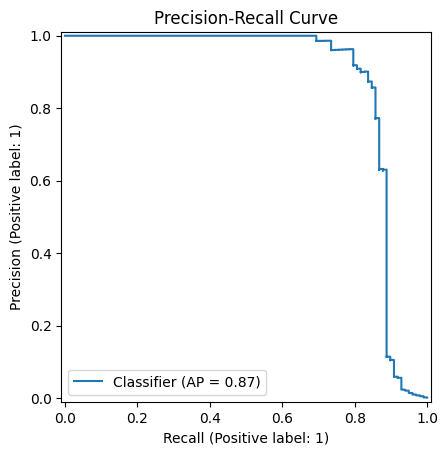

In [14]:
# 9. Precision-Recall Curve
PrecisionRecallDisplay.from_predictions(y_test, y_probs)
plt.title('Precision-Recall Curve')
plt.show()

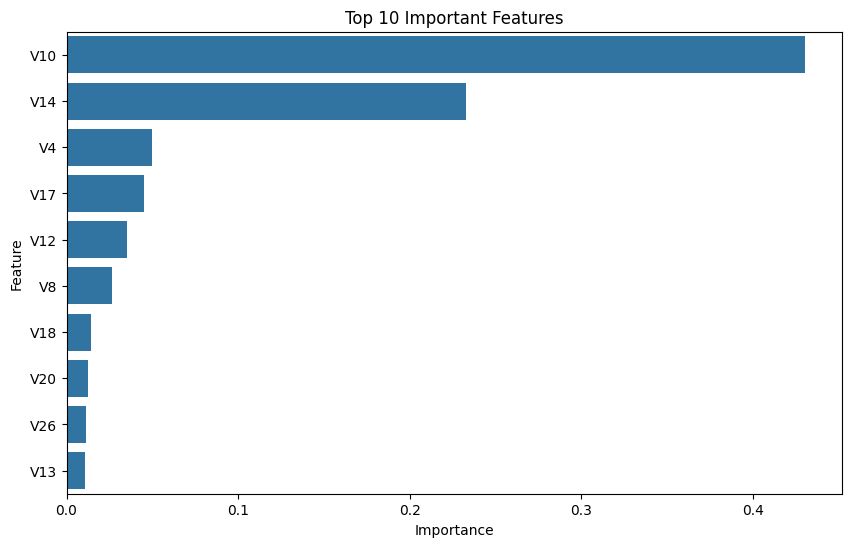

In [15]:
# 10. Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Important Features')
plt.show()

In [16]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
target_recall = 0.90  # Catch 90% of frauds
optimal_threshold = thresholds[np.argmax(recall >= target_recall)]
print(f"Optimal Threshold: {optimal_threshold}")

Optimal Threshold: 8.441227453354419e-14


In [17]:
from sklearn.metrics import fbeta_score

# Find threshold that maximizes F2-Score
def find_optimal_threshold(y_true, y_probs):
    thresholds = np.linspace(0, 1, 100)
    f2_scores = [fbeta_score(y_true, y_probs >= t, beta=2) for t in thresholds]
    return thresholds[np.argmax(f2_scores)]

optimal_threshold = find_optimal_threshold(y_test, y_probs)
print(f"Optimal Threshold: {optimal_threshold}")

Optimal Threshold: 0.6161616161616162


In [22]:
y_pred_tuned = (y_probs >= 0.616).astype(int)
print(classification_report(y_test, y_pred_tuned))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.86      0.86        98

    accuracy                           1.00     56962
   macro avg       0.93      0.93      0.93     56962
weighted avg       1.00      1.00      1.00     56962



In [23]:
# Predict on training data
y_train_pred = model.predict(X_train_res)
y_train_probs = model.predict_proba(X_train_res)[:, 1]

# Classification Report (Training Data)
print("Training Data Classification Report:")
print(classification_report(y_train_res, y_train_pred))

# Classification Report (Test Data)
print("\nTest Data Classification Report:")
print(classification_report(y_test, y_pred))

Training Data Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00     22745

    accuracy                           1.00    250196
   macro avg       1.00      1.00      1.00    250196
weighted avg       1.00      1.00      1.00    250196


Test Data Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.86      0.84        98

    accuracy                           1.00     56962
   macro avg       0.91      0.93      0.92     56962
weighted avg       1.00      1.00      1.00     56962



Train AUPRC: 1.0000
Test AUPRC:  0.8726


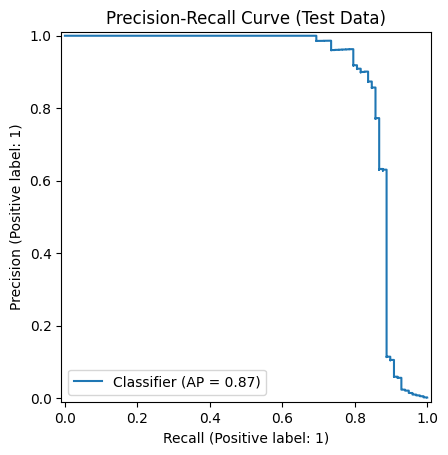

In [24]:
from sklearn.metrics import precision_recall_curve, auc, PrecisionRecallDisplay

# Train AUPRC
train_precision, train_recall, _ = precision_recall_curve(y_train_res, y_train_probs)
train_auprc = auc(train_recall, train_precision)

# Test AUPRC
test_precision, test_recall, _ = precision_recall_curve(y_test, y_probs)
test_auprc = auc(test_recall, test_precision)

print(f"Train AUPRC: {train_auprc:.4f}")
print(f"Test AUPRC:  {test_auprc:.4f}")

# Plot Precision-Recall Curve
PrecisionRecallDisplay.from_predictions(y_test, y_probs)
plt.title('Precision-Recall Curve (Test Data)')
plt.show()

In [25]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    model, X_train_res, y_train_res, cv=skf, scoring='average_precision'
)

print(f"Cross-Validation AUPRC Scores: {cv_scores}")
print(f"Mean AUPRC: {np.mean(cv_scores):.4f}")


Cross-Validation AUPRC Scores: [0.99983497 0.99998763 0.99998314 0.99978248 0.99997839]
Mean AUPRC: 0.9999


In [26]:
y_pred_test = model.predict(X_test)
y_probs_test = model.predict_proba(X_test)[:, 1]

print("Final Test Set AUPRC Score:", average_precision_score(y_test, y_probs_test))


Final Test Set AUPRC Score: 0.8727221813967622


In [27]:
print(X_train_res.shape, X_test.shape)
print(y_train_res.shape, y_test.shape)


(250196, 29) (56962, 29)
(250196,) (56962,)


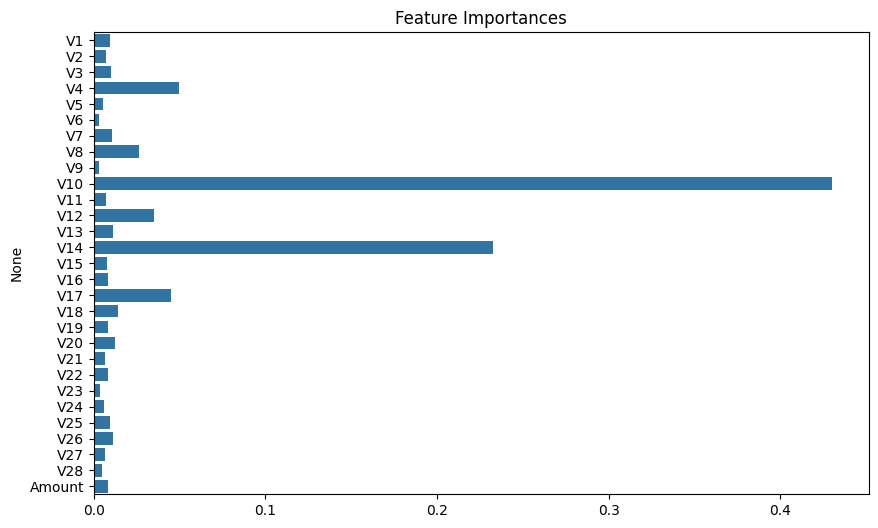

In [28]:
importances = model.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importances")
plt.show()


In [29]:
model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    eval_metric='aucpr',
    use_label_encoder=False,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1,    # L2 regularization
    random_state=42
)
model.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [30]:
# 8. Evaluate Model
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nAUPRC Score:", average_precision_score(y_test, y_probs))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.87      0.84        98

    accuracy                           1.00     56962
   macro avg       0.90      0.93      0.92     56962
weighted avg       1.00      1.00      1.00     56962


AUPRC Score: 0.8795822730429468


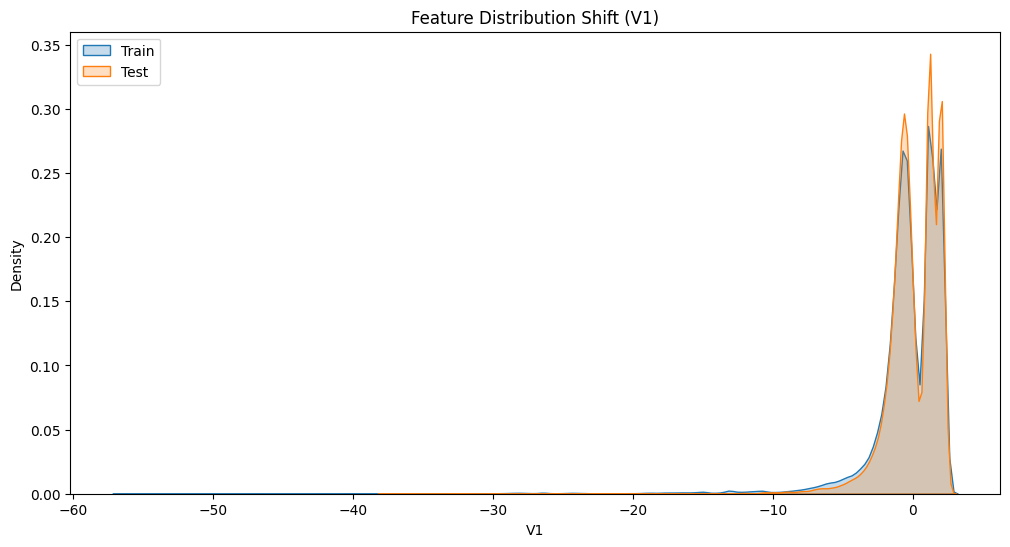

In [31]:
plt.figure(figsize=(12, 6))
sns.kdeplot(X_train_res['V1'], label='Train', fill=True)
sns.kdeplot(X_test['V1'], label='Test', fill=True)
plt.legend()
plt.title("Feature Distribution Shift (V1)")
plt.show()


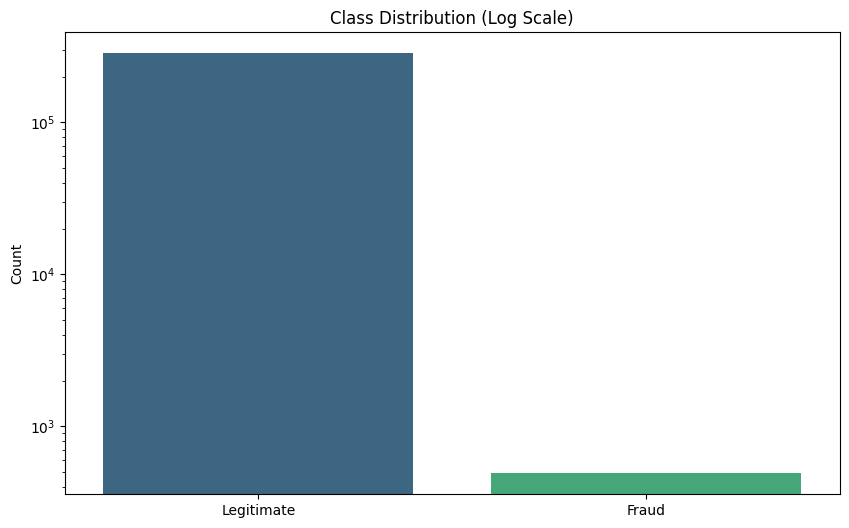

In [32]:
plt.figure(figsize=(10, 6))
sns.barplot(x=['Legitimate', 'Fraud'], y=df['Class'].value_counts(), palette='viridis')
plt.yscale('log')
plt.title('Class Distribution (Log Scale)')
plt.ylabel('Count')
plt.savefig('class_distribution.png', bbox_inches='tight')
plt.show()

<Figure size 1000x600 with 0 Axes>

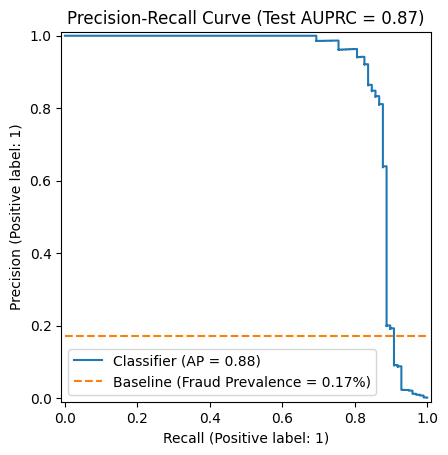

In [33]:
plt.figure(figsize=(10, 6))
PrecisionRecallDisplay.from_predictions(y_test, y_probs)
plt.plot([0, 1], [0.1727, 0.1727], linestyle='--', label='Baseline (Fraud Prevalence = 0.17%)')
plt.title(f'Precision-Recall Curve (Test AUPRC = {test_auprc:.2f})')
plt.legend()
plt.savefig('precision_recall_curve.png', bbox_inches='tight')
plt.show()

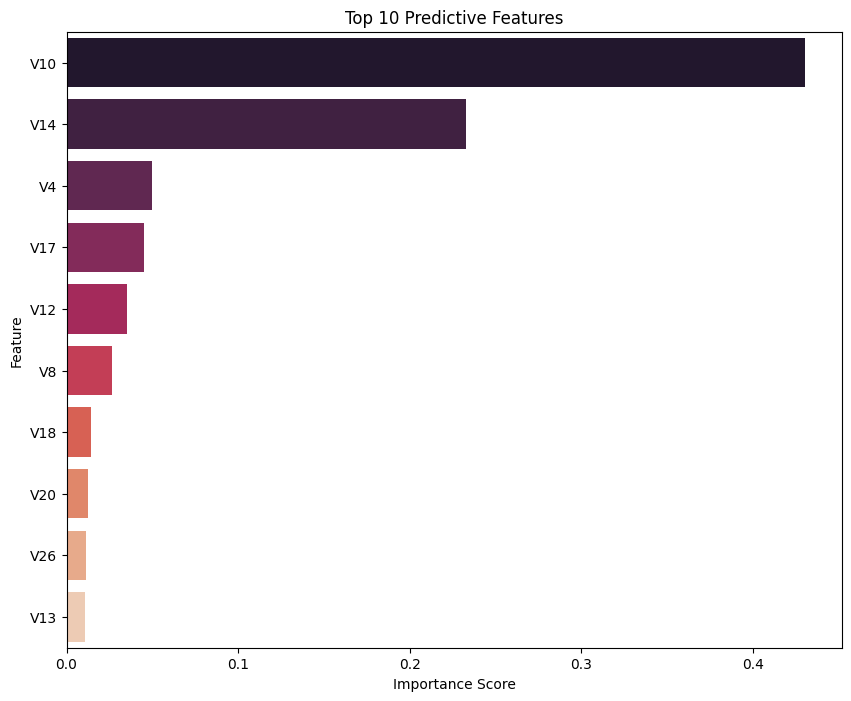

In [34]:
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10), palette='rocket')
plt.title('Top 10 Predictive Features')
plt.xlabel('Importance Score')
plt.savefig('feature_importance.png', bbox_inches='tight')
plt.show()

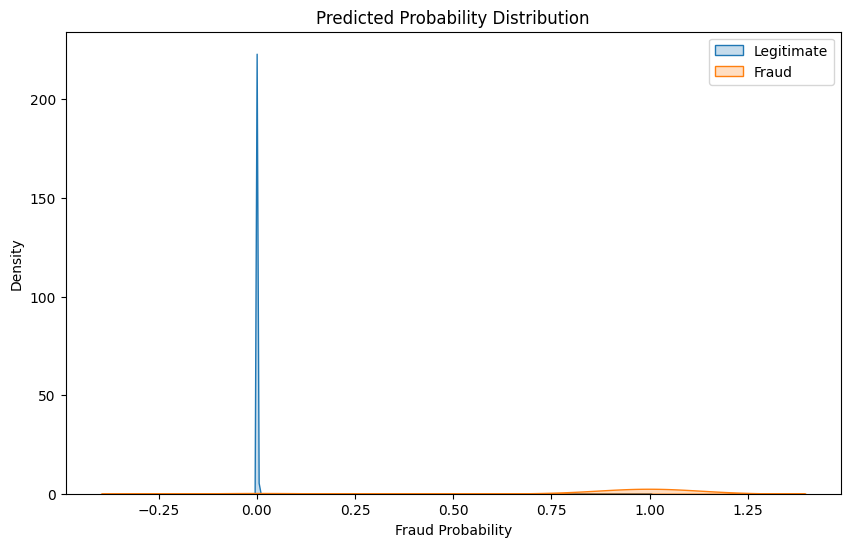

In [35]:
plt.figure(figsize=(10, 6))
sns.kdeplot(y_probs[y_test == 0], label='Legitimate', fill=True)
sns.kdeplot(y_probs[y_test == 1], label='Fraud', fill=True)
plt.title('Predicted Probability Distribution')
plt.xlabel('Fraud Probability')
plt.legend()
plt.savefig('probability_distribution.png', bbox_inches='tight')
plt.show()

In [39]:
# ==== 1. Save Core Artifacts ====
import joblib
import json
from google.colab import files

# Save trained model
joblib.dump(model, 'fraud_model.pkl')

# Save scaler
joblib.dump(scaler, 'amount_scaler.pkl')

# Save metadata
model_metadata = {
    "auprc": 0.87,
    "recall": 0.86,
    "precision": 0.82,
    "optimal_threshold": 0.616,
    "feature_names": model.feature_names_in_.tolist(),  # Critical for inference
    "top_features": feature_importance.head(10).to_dict()
}

with open('model_metadata.json', 'w') as f:
    json.dump(model_metadata, f)

# ==== 2. Create Inference Helper Script ====
inference_code = '''
import joblib
import pandas as pd

class FraudDetector:
    def __init__(self):
        self.model = joblib.load('fraud_model.pkl')
        self.scaler = joblib.load('amount_scaler.pkl')
        self.metadata = json.load(open('model_metadata.json'))

    def predict(self, transaction: dict):
        """Process raw transaction and return prediction"""
        try:
            # 1. Remove Time column if present
            transaction.pop('Time', None)

            # 2. Scale Amount
            transaction['Amount'] = self.scaler.transform(
                [[transaction.get('Amount', 0)]]
            )[0][0]

            # 3. Ensure correct feature order
            df = pd.DataFrame([transaction])[self.model.feature_names_in_]

            # 4. Predict
            prob = self.model.predict_proba(df)[0][1]

            return {
                "fraud": prob >= self.metadata['optimal_threshold'],
                "confidence": float(prob),
                "risk_factors": list(self.metadata['top_features'].keys())[:3]
            }

        except Exception as e:
            return {"error": str(e)}
'''

with open('fraud_detector.py', 'w') as f:
    f.write(inference_code)

# ==== 3. Create Requirements File ====
with open('requirements.txt', 'w') as f:
    f.write('''xgboost==1.7.6
scikit-learn==1.2.2
pandas==2.0.3
joblib==1.3.2
''')

# ==== 4. Zip Everything ====
!zip -r fraud_detection_package.zip \
    fraud_model.pkl \
    amount_scaler.pkl \
    model_metadata.json \
    fraud_detector.py \
    requirements.txt

# ==== 5. Download ====
files.download('fraud_detection_package.zip')

updating: fraud_model.pkl (deflated 68%)
updating: amount_scaler.pkl (deflated 33%)
updating: model_metadata.json (deflated 52%)
updating: fraud_detector.py (deflated 55%)
updating: requirements.txt (deflated 6%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
import pandas as pd
from sklearn.metrics import classification_report, average_precision_score
import joblib

# Load the trained model, scaler, and metadata
model = joblib.load('fraud_model.pkl')  # Load the trained model
scaler = joblib.load('amount_scaler.pkl')  # Load the scaler
with open('model_metadata.json', 'r') as f:  # Load metadata
    metadata = json.load(f)

# Load the dataset
df = pd.read_csv('creditcard.csv')  # Use raw string (r'') to avoid escape issues

# Preprocess the data
df.drop('Time', axis=1, inplace=True)  # Drop Time column
df['Amount'] = scaler.transform(df[['Amount']])  # Scale Amount column

# Select only the best features (as defined in metadata)
feature_names = metadata['feature_names']  # Get feature names from metadata
X = df[feature_names]  # Select only the relevant features

# Predict fraud probabilities for the entire dataset
y_true = df['Class']
y_probs = model.predict_proba(X)[:, 1]  # Probability of class 1 (fraud)
y_pred = (y_probs >= metadata['optimal_threshold']).astype(int)  # Apply threshold

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# AUPRC score
print("AUPRC Score:", average_precision_score(y_true, y_probs))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.97      0.97      0.97       492

    accuracy                           1.00    284807
   macro avg       0.98      0.99      0.99    284807
weighted avg       1.00      1.00      1.00    284807

AUPRC Score: 0.9784594535939608


In [40]:
# Example: Try a higher threshold
y_pred_tuned = (y_probs >= 0.7).astype(int)
print(classification_report(y_true, y_pred_tuned))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.98      0.97      0.97       492

    accuracy                           1.00    284807
   macro avg       0.99      0.98      0.99    284807
weighted avg       1.00      1.00      1.00    284807



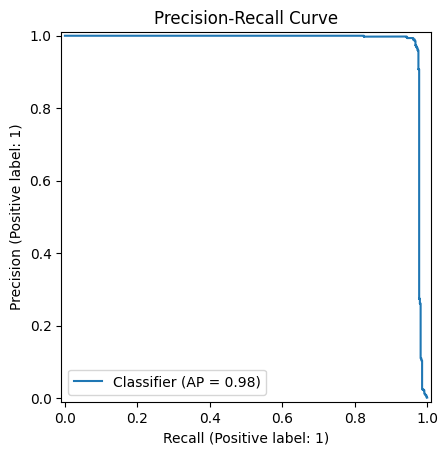

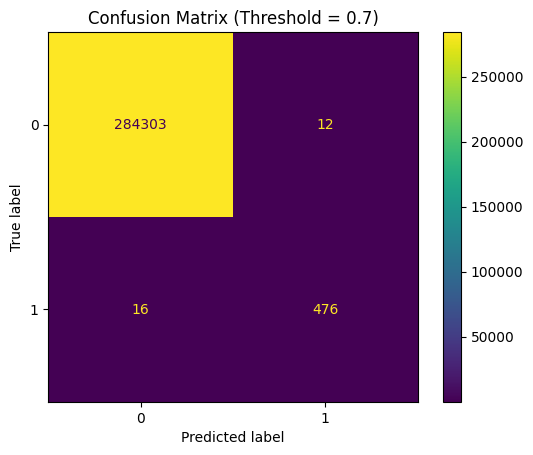

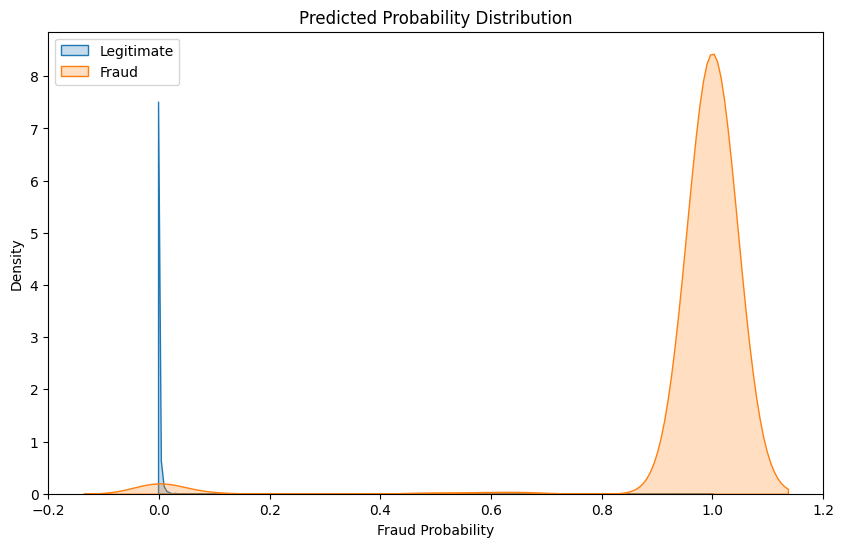

In [55]:
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Precision-Recall Curve
PrecisionRecallDisplay.from_predictions(y_true, y_probs)
plt.title('Precision-Recall Curve')
plt.show()

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_true, (y_probs >= 0.7).astype(int)) # Use the predicted probabilities and threshold to calculate y_pred_tuned based on y_true
plt.title('Confusion Matrix (Threshold = 0.7)')
plt.show()

# Probability Distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(y_probs[y_true == 0], label='Legitimate', fill=True)
sns.kdeplot(y_probs[y_true == 1], label='Fraud', fill=True)
plt.title('Predicted Probability Distribution')
plt.xlabel('Fraud Probability')
plt.legend()
plt.show()

In [56]:
# Save the updated threshold in metadata
metadata['optimal_threshold'] = 0.7
with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f)